[<img src="../../header.svg">](../index.ipynb)

---

# Two grid method

Simple iterative methods are slow to converge. Let us import everything we did before...

Loading Domain './grids/laplace_sample_grid_2d-tri.ugx'...
Domain loaded.
Refining ...
Refining step {0} ...
Refining step {1} ...
Refining step {2} ...
Refining step {3} ...
Refining step {4} ...
Refining done
Approximation space:
| ---------------------------------------------------------------------------- |
|  Number of DoFs (All Procs)                                                  |
|  Algebra: Block 1 (divide by 1 for #Index)                                   |
|                                                                              |
|    GridLevel   |       Domain |     0: Inner |  1: Boundary                  |
| ---------------------------------------------------------------------------- |
| (lev,    0)    |            9 |            1 |            8 |
| (lev,    1)    |           25 |            9 |           16 |
| (lev,    2)    |           81 |           49 |           32 |
| (lev,    3)    |          289 |          225 |           64 |
| (lev,    4)    |        

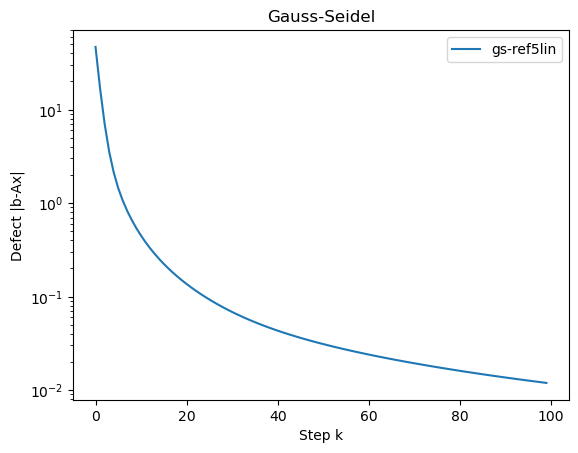

Widget(value='<iframe src="http://localhost:64395/index.html?ui=P_0x29469a570_4&reconnect=auto" class="pyvista…

In [14]:
%run example01-smoothers.ipynb



## Definition of the two-grid method

The convergence rate $\kappa$ of simple iterative method slows down under refinement. We have $\kappa\rightarrow 1$ for $h\rightarrow 0$. $h$-independent convergence rates are obtained, if smoothing is combined with coarse grid correction:

<ins>Given:</ins> 
\begin{align}
\text{Fine problem: }&  A_h x_h = b_h &\text{ on }\Omega_h ,\\
\text{Coarse problem: }&  A_H x_H = b_H &\text{ on }\Omega_H
\end{align}

<ins>Algorithm:</ins> `ZGV`($A_h, x_h, b_h$)

* Pre-smoothing:
>for i=1:$\nu_1$ do
>
>    $\hspace{3em}x_h := x_h + M^{-1}(b_h-A_h x_h)$ 
>
> end 

* Coarse grid correction(exact!)
> $d_H := r (b_h-A_h x_h)$ 
>
> `Löse` $A_H e_H = d_H$
>
> $x_h := x_h + p e_H$ 

* Post-smoothing (optional, e.g., to maintain symmetry):
>for i=1:$\nu_2$ do
>
>    $\hspace{3em}x_h := x_h + M^{-1}(b_h-A_h x_h)$ 
>
> end 

* return:
> `return` $x_l$;



In [15]:
#solver:set_preconditioner(GaussSeidel())
#SolverTest(domainDisc, approxSpace, solver, "SmootherError.vtk");


## Configuration of the two grid method

### Parameter
* Smoother $M$
* Number of smoothing steps $\nu$
* Interpolation $p : \mathbb R^{I_H} \rightarrow \mathbb  R^{I_h}$ ("coarse to fine", e.g., linear interpolation)
* Restriction $r : \mathbb R^{I_H} \rightarrow \mathbb  R^{I_h}$ ("fine to coarse", e.g., injection)
* Computing $A_H$, e.g., $A_H:=r \,A_h\, p$

In [16]:
numRefs = myRefs

mg = ugcore.GeometricMultiGrid2dCPU1(approxSpace)
mg.set_base_level(numRefs-1)       # Two grid method
mg.set_discretization(domainDisc)

mg.set_smoother(preconditioners["jac"])    # Select smoother
mg.set_num_presmooth(2)           # pre smoothing
mg.set_num_postsmooth(0)           # pre smoothing

mg.set_rap(True)                   # Galerkin product A_H=RAP; if true (alternative: assemble coarse system)


In [17]:
solver = ugcore.LinearSolverCPU1()
solver.set_convergence_check(convCheck)
solver.set_preconditioner(mg)

## Convergence


Now, test the two-grid method.

In [18]:
# Test fuer Level L, L-1
solver.set_preconditioner(mg)
history["two-grid1"] = SolverTest(domainDisc, approxSpace, solver, "Error_TwoGrid1.vtk")
result = pyvista.read( "Error_TwoGrid1.vtu")
result.plot(scalars="u", show_edges=True, cmap='jet')


   % %%%%%%%%      Iterative Linear Solver      %%%%%%%%%%%
   % %%%%%%%%   (Precond: Geometric MultiGrid)  %%%%%%%%%%%
   % Results: 14 steps (rho=0.3683886194264074)
Time: 0.031934 seconds
  Iter      Defect         Rate 
   %    0:    1.595483e+02      -------
   %    1:    1.755047e+01    1.100010e-01
   %    2:    5.000507e+00    2.849216e-01
   %    3:    1.870335e+00    3.740292e-01
   %    4:    7.432565e-01    3.973921e-01
   %    5:    3.029089e-01    4.075429e-01
   %    6:    1.252999e-01    4.136555e-01
   %    7:    5.236076e-02    4.178834e-01
   %    8:    2.204679e-02    4.210556e-01
   %    9:    9.338390e-03    4.235714e-01
   %   10:    3.974844e-03    4.256456e-01
   %   11:    1.698861e-03    4.274032e-01
   %   12:    7.286793e-04    4.289223e-01
   %   13:    3.135177e-04    4.302547e-01
   %   14:    1.352630e-04    4.314366e-01
   % Relative reduction 1.000000e-06 reached after 14 steps.
   % Average reduction over 14 steps: 3.683886e-01
   % %%%%%  Iteration

Widget(value='<iframe src="http://localhost:64395/index.html?ui=P_0x2838bdc10_5&reconnect=auto" class="pyvista…

The two-grid method converges independent of the mesh size h. To illustrate, refine the grid and apply the method again. Note that the defect changes (due to the larger number of unknown), bit the convergence rate remains constant:

In [19]:
# Test fuer Level L+1, L
refiner = ugcore.GlobalDomainRefiner(approxSpace.domain())
refiner.refine()

mg.set_base_level(numRefs) # Adjust coarse level!

# Repeat test
history["two-grid2"] = SolverTest(domainDisc, approxSpace, solver, "Error_TwoGrid2.vtk")
result = pyvista.read( "Error_TwoGrid2.vtu")
result.plot(scalars="u", show_edges=True, cmap='jet')


ILUT: please use 'set_ordering_algorithm(..)' in the future
Results: 14 steps (rho=0.368138253613734)
Time: 0.1262 seconds

   % %%%%%%%%      Iterative Linear Solver      %%%%%%%%%%%
   % %%%%%%%%   (Precond: Geometric MultiGrid)  %%%%%%%%%%%
   %   Iter      Defect         Rate 
   %    0:    3.291969e+02      -------
   %    1:    3.502034e+01    1.063811e-01
   %    2:    9.890695e+00    2.824271e-01
   %    3:    3.723597e+00    3.764748e-01
   %    4:    1.487965e+00    3.996043e-01
   %    5:    6.089399e-01    4.092433e-01
   %    6:    2.527576e-01    4.150782e-01
   %    7:    1.059390e-01    4.191326e-01
   %    8:    4.472270e-02    4.221553e-01
   %    9:    1.898556e-02    4.245174e-01
   %   10:    8.095991e-03    4.264288e-01
   %   11:    3.465228e-03    4.280178e-01
   %   12:    1.487857e-03    4.293677e-01
   %   13:    6.405742e-04    4.305347e-01
   %   14:    2.764452e-04    4.315584e-01
   % Relative reduction 1.000000e-06 reached after 14 steps.
   % Average r

Widget(value='<iframe src="http://localhost:64395/index.html?ui=P_0x2838bdb20_6&reconnect=auto" class="pyvista…

## Approximation and Smoothing property

Betrachten wir den Fehlerfortpflanzungsoperator $ T_{ZGV} (\nu_1, \nu_2)= S_{2}^{\nu_2}(I-pA_H^{-1}rA) S_{1}^{\nu_1}$ für den Fall nur mit Vorglättung, so ergibt sich:
$$  T_{ZGV} (\nu_,0)  =(I-pA_H^{-1}rA) S^{\nu} = (A^{-1}-pA_H^{-1}r) AS^{\nu}$$

Das Verfahren konvergiert, falls Approximations und Glättungseigenschaft erfüllt sind. Es gebe also $C_S,C_A >0$ und eine Funktion $\eta : \mathbb N \rightarrow \mathbb R^+$, so dass 
$$\|A^{-1} - pA_H^{-1}r\| \le C_A h^2 $$
$$\|A S^{\nu}\| \le C_S \frac{1}{h^2} \eta(\nu), $$
wobei $\eta(\nu) \rightarrow 0$ für $\nu \rightarrow \infty$. Das Verfahren konvergiert demnach für hinreichend viele Glättungsschritte. Die Konvergenzrate wird besser, je mehr Glättungsschritte verwendet werden. Im Folgenden sehen wir, dass sie sich für dieses Beispiel etwa wie $\frac{1}{\nu}$ verhält:

In [20]:
historyTwoGrid = {}

for nu in range(1,6):
    mg.set_num_presmooth(nu)
    historyTwoGrid[nu] = SolverTest(domainDisc, approxSpace, solver, "ErrorZGV")
    print()
    print("1/nu=" + str(1.0/nu))
    print()
    print("=========")



ILUT: please use 'set_ordering_algorithm(..)' in the future
Results: 28 steps (rho=0.601835262896011)
Time: 0.149627 seconds

   % %%%%%%%%      Iterative Linear Solver      %%%%%%%%%%%
   % %%%%%%%%   (Precond: Geometric MultiGrid)  %%%%%%%%%%%
   %   Iter      Defect         Rate 
   %    0:    3.291969e+02      -------
   %    1:    8.071220e+01    2.451791e-01
   %    2:    3.155397e+01    3.909442e-01
   %    3:    1.604235e+01    5.084098e-01
   %    4:    9.132513e+00    5.692753e-01
   %    5:    5.457167e+00    5.975537e-01
   %    6:    3.338945e+00    6.118459e-01
   %    7:    2.071518e+00    6.204110e-01
   %    8:    1.297449e+00    6.263276e-01
   %    9:    8.184388e-01    6.308061e-01
   %   10:    5.192067e-01    6.343867e-01
   %   11:    3.309156e-01    6.373486e-01
   %   12:    2.117380e-01    6.398550e-01
   %   13:    1.359381e-01    6.420108e-01
   %   14:    8.752893e-02    6.438881e-01
   %   15:    5.650330e-02    6.455386e-01
   %   16:    3.655769e-02    

Mehr Glättungssschritte bedeuten natürlich mehr Aufwand pro Iteration. Man beachte, dass der Sweetspot bzgl. der Zeit in diesem Fall bei $\nu=3$ liegt. Zuletzt wollen wir die Ergebnisse noch plotten:

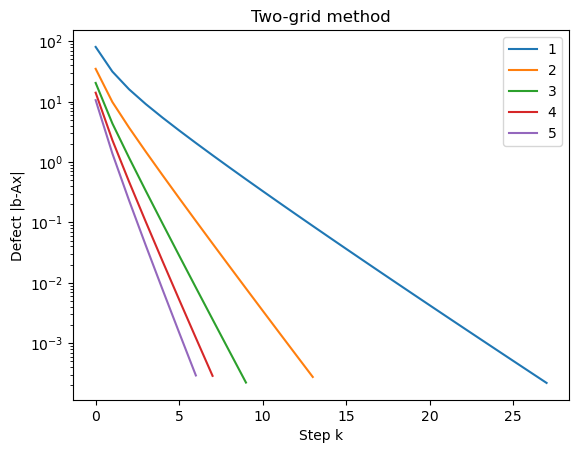

In [21]:
PlotResults(historyTwoGrid, "Two-grid method")

# Convergence of the two-grid method 


## Approximation property

We need an estimate of the form

$$ \|A_h^{-1} - p A_H^{-1} r\| = \sup\limits_{f_h} \|(A_h^{-1} - p A_H^{-1} r) f_h\| \le \frac{C_A}{\|A_h\|}
$$

This requires knowledge on the discretization. For arbitrary $f_h$ we find:
\begin{eqnarray}
\|(A_h^{-1} - p A_H^{-1} r) f_h\| &=&  \|(A_h^{-1}f_h - p A_H^{-1} r f_h\| \\
&=&  \| u_h -  p \tilde u_H\| 
\end{eqnarray}

## Smoothing property

The smoothing property can be shown algebraically.


The result then follows from the following argument:

### Analysis of $ f_{\nu}(\lambda) =(1-\lambda)\cdot \lambda^\nu$

In [38]:
def mypoly (lamb, nu):
    return (1.0-lamb)*lamb**nu;


The maximum of this function in the interval $(-\alpha,1]$ tends to zero for $\nu \rightarrow \infty$.

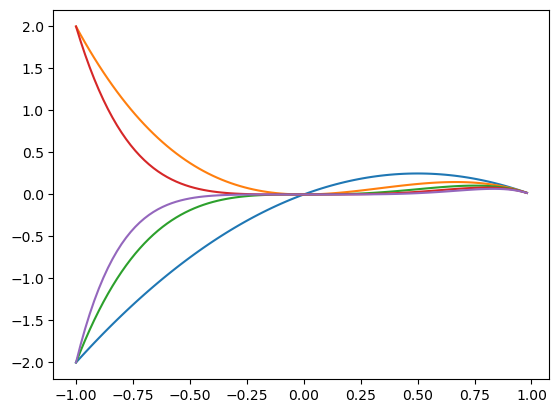

In [41]:
mylambda = np.arange(-1.0, 1.0, 0.02)
import numpy as np
import matplotlib.pyplot as plt

plt.plot(mylambda,mypoly(mylambda, 1), label="lambda=1")
plt.plot(mylambda,mypoly(mylambda, 2), label="lambda=2")
plt.plot(mylambda,mypoly(mylambda, 3), label="lambda=3")
plt.plot(mylambda,mypoly(mylambda, 4), label="lambda=4")
plt.plot(mylambda,mypoly(mylambda, 5), label="lambda=5")


### Ausblick: Konstruktion robuster Glätter
Für singulär gestörte Probleme werden häufig **robuste Glätter** benötigt. Am Beispiel der anisotropen Diffusion haebn wir gesehen, dass sich die **Approximationseigenschaft** verschlechtert. Es gilt lediglich:

$$ \|A_h^{-1} - p A_{H}^{-1} r \| \le C_A \frac{h^2}{\epsilon}
$$
Damit Konvergenz gegeben ist, muss ein Glätter eingesetzt werden, dessen **Glättungseigenschaft** dies entsprechend kompensiert. Es sollte also gelten:
$$ \|A_h S_h^{\nu}\| \le C_s \frac{\epsilon }{h^2} \eta(\nu)
$$


Um dies zu zeigen, spaltet man wie folgt auf:

\begin{eqnarray}
\| A S^\nu \| &=& \| M^{\frac{1}{2}} (I-X) X^\nu M^{\frac{1}{2}}\| \\
 &=& \| M^{\frac{1}{2}} (I-X) X^{\nu-1} (M^{-\frac{1}{2}} N  M^{-\frac{1}{2}}) M^{\frac{1}{2}}\| \\
  &\le& \| M^{\frac{1}{2}} (I-X) X^{\nu-1} M^{-\frac{1}{2}} \|\| N  (M^{-\frac{1}{2}} M^{\frac{1}{2}})\| \\
 &=&  \| M^{\frac{1}{2}} (I-X) X^{\nu-1} M^{-\frac{1}{2}} \|\| N \| 
\end{eqnarray}
Die Glättungseigenschaft folgt dann, falls $(I-X)X^{\nu-1} \approx \eta(\nu-1)$ und 
$$\|N \| \le C_s \frac{\epsilon }{h^2}.$$